In [ ]:

# === SETUP FOR GOOGLE COLAB ===

# Uncomment below to mount Google Drive if needed
# from google.colab import drive
# drive.mount('/content/drive')

# Install required packages
!pip install wfdb lightgbm scikit-learn matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import img_as_ubyte

# Display images inline
%matplotlib inline


Saving Sheela Devi.jpg to Sheela Devi (1).jpg


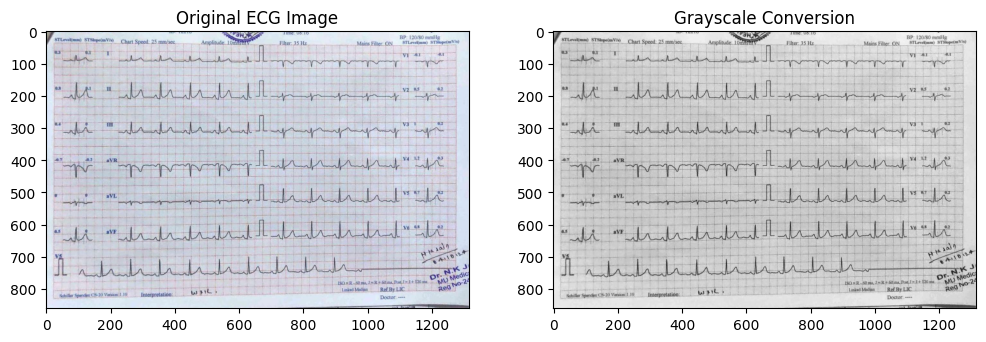

✅ Successfully loaded: Sheela Devi (1).jpg
📐 Image dimensions: 1315x861 pixels
🌈 Color channels: Color


In [ ]:
####################
### 1. Image Loading & Preprocessing
####################
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

def load_ecg_image():
    """Load ECG image with robust error handling and auto-orientation correction"""
    # Upload image
    uploaded = files.upload()
    if not uploaded:
        raise FileNotFoundError("❌ No file uploaded. Please upload an ECG image.")

    # Get first uploaded file
    file_name, file_bytes = next(iter(uploaded.items()))

    # Decode image with multiple format attempts
    try:
        image = cv2.imdecode(np.frombuffer(file_bytes, np.uint8), cv2.IMREAD_COLOR)
        if image is None:
            raise ValueError("Unsupported image format")
    except Exception as e:
        raise RuntimeError(f"❌ Image decoding failed: {str(e)}") from e

    # Auto-rotate based on EXIF orientation (common in mobile photos)
    try:
        from PIL import Image, ExifTags
        pil_img = Image.open(io.BytesIO(file_bytes))
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = dict(pil_img._getexif().items())

        if exif[orientation] == 3:
            image = cv2.rotate(image, cv2.ROTATE_180)
        elif exif[orientation] == 6:
            image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        elif exif[orientation] == 8:
            image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    except:
        pass  # EXIF data not available

    # Convert to RGB and grayscale
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Display diagnostics
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.imshow(image_rgb), plt.title("Original ECG Image")
    plt.subplot(122), plt.imshow(image_gray, cmap='gray'), plt.title("Grayscale Conversion")
    plt.show()

    print(f"✅ Successfully loaded: {file_name}")
    print(f"📐 Image dimensions: {image_gray.shape[1]}x{image_gray.shape[0]} pixels")
    print(f"🌈 Color channels: {'Color' if len(image.shape)==3 else 'Grayscale'}")

    return image_rgb, image_gray

# Usage:
ecg_rgb, ecg_gray = load_ecg_image()

In [ ]:
####################
### 2. Grid Line Removal (ECG-Optimized)
####################
def remove_ecg_grid(image_gray, display_steps=True):
    """
    Enhanced grid removal pipeline for ECG paper tracings
    Returns grid-free binary image and detected grid lines
    """
    # Adaptive thresholding with ECG-optimized parameters
    thresh = cv2.adaptiveThreshold(
        image_gray,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Better for ECG than MEAN
        cv2.THRESH_BINARY_INV,
        blockSize=21,  # Odd size > typical ECG line width
        C=7
    )

    # ECG-specific morphological operations
    line_length_pixels = int(image_gray.shape[1] * 0.2)  # Dynamic kernel sizing
    horizontal_kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT,
        (line_length_pixels, 1)
    )
    vertical_kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT,
        (1, line_length_pixels)
    )

    # Grid detection with ECG protection
    horizontal_lines = cv2.morphologyEx(
        thresh,
        cv2.MORPH_OPEN,
        horizontal_kernel,
        iterations=2
    )

    vertical_lines = cv2.morphologyEx(
        thresh,
        cv2.MORPH_OPEN,
        vertical_kernel,
        iterations=2
    )

    # Smart grid subtraction (protects signal)
    grid_mask = cv2.add(horizontal_lines, vertical_lines)
    grid_removed = cv2.subtract(thresh, grid_mask)

    # Post-processing to reconnect broken ECG lines
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    grid_removed = cv2.morphologyEx(grid_removed, cv2.MORPH_CLOSE, repair_kernel)

    if display_steps:
        plt.figure(figsize=(18, 6))

        # plt.subplot(1, 3, 1)
        # plt.imshow(horizontal_lines, cmap='gray')
        # plt.title(f"Horizontal Grid\n(Kernel: {horizontal_kernel.shape})")
        # plt.axis("off")

        # plt.subplot(1, 3, 2)
        # plt.imshow(vertical_lines, cmap='gray')
        # plt.title(f"Vertical Grid\n(Kernel: {vertical_kernel.shape})")
        # plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(grid_removed, cmap='gray')
        plt.title("ECG Signal After Grid Removal\n(With Signal Repair)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return grid_removed, grid_mask

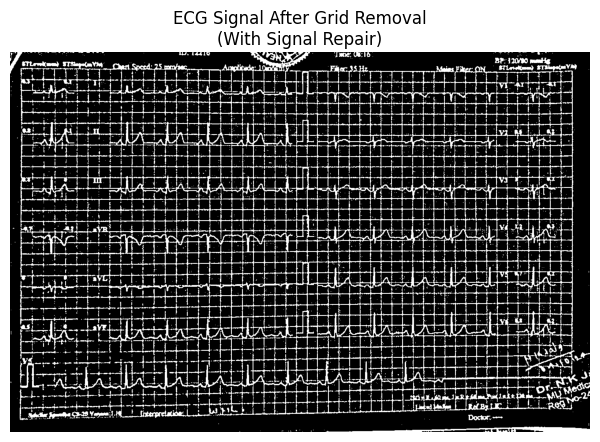

In [ ]:
grid_removed, grid_mask = remove_ecg_grid(ecg_gray)  # Where ecg_gray is your grayscale image

In [ ]:
####################
### 3. Lead Segmentation (Flexible Approach)
####################
def segment_ecg_leads(image, method='auto', lead_labels=None, display=True):
    """
    Segments 12-lead ECG image with two approaches:
    1. 'auto' - Automatic equal splitting (default)
    2. 'mask' - Predefined template matching (more accurate)

    Args:
        image: RGB ECG image (after grid removal)
        method: 'auto' or 'mask'
        lead_labels: List of 12 lead names
        display: Show segmentation results

    Returns:
        Dictionary of {lead_name: lead_image}
    """
    # Standard lead labels if not provided
    if lead_labels is None:
        lead_labels = ["I", "II", "III", "aVR", "aVL", "aVF",
                       "V1", "V2", "V3", "V4", "V5", "V6"]

    h, w = image.shape[:2]
    leads = {}

    if method == 'auto':
        # Automatic equal splitting (your current approach improved)
        mid_x = w // 2
        left_col = image[:, :mid_x]
        right_col = image[:, mid_x:]

        def split_column(col_img, is_left=True):
            row_h = col_img.shape[0] // 6
            return [col_img[i*row_h : (i+1)*row_h, :] for i in range(6)]

        left_leads = split_column(left_col)
        right_leads = split_column(right_col)
        lead_images = left_leads + right_leads

    elif method == 'mask':
        # Mask-based approach (more accurate for non-standard ECGs)
        # Create approximate lead regions (adjust ratios based on your ECG format)
        lead_regions =[
            # Left Column (Limbs)
            (0, 0,        w//2, h//6),    # I
            (0, h//6,     w//2, h//3),    # II
            (0, h//3,     w//2, h//2),    # III
            (0, h//2,     w//2, 2*h//3),  # aVR
            (0, 2*h//3,   w//2, 5*h//6),  # aVL
            (0, 5*h//6,   w//2, h),      # aVF

            # Right Column (Precordial)
            (w//2, 0,     w, h//6),      # V1
            (w//2, h//6,  w, h//3),      # V2
            (w//2, h//3,  w, h//2),      # V3
            (w//2, h//2,  w, 2*h//3),    # V4
            (w//2, 2*h//3,w, 5*h//6),    # V5
            (w//2, 5*h//6,w, h)          # V6
        ]
        lead_images = [image[y1:y2, x1:x2] for (x1,y1,x2,y2) in lead_regions]

    # Store in dictionary with labels
    leads = {label: img for label, img in zip(lead_labels, lead_images)}

    if display:
        plt.figure(figsize=(15, 8))
        for i, (label, lead_img) in enumerate(leads.items()):
            plt.subplot(3, 4, i+1)
            plt.imshow(lead_img)
            plt.title(f"Lead {label}", pad=2)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    return leads

# Usage examples:
# 1. Automatic splitting (default)
# leads_auto = segment_ecg_leads(image)

# 2. Mask-based (requires region definitions)
# leads_mask = segment_ecg_leads(image, method='mask')

Saving Sheela Devi.jpg to Sheela Devi.jpg


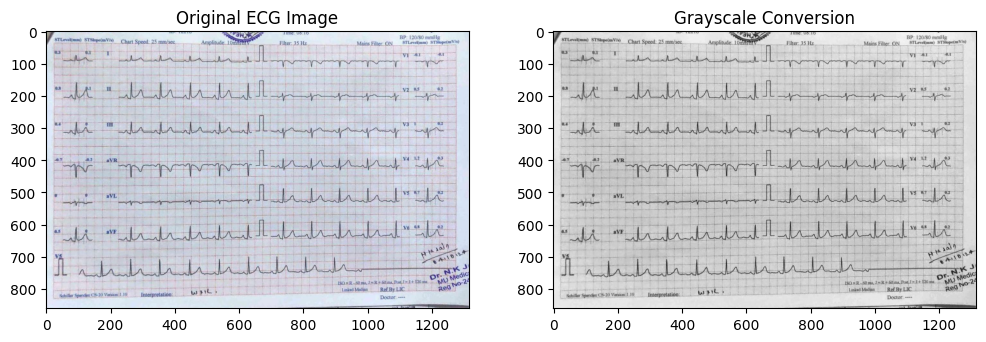

✅ Successfully loaded: Sheela Devi.jpg
📐 Image dimensions: 1315x861 pixels
🌈 Color channels: Color


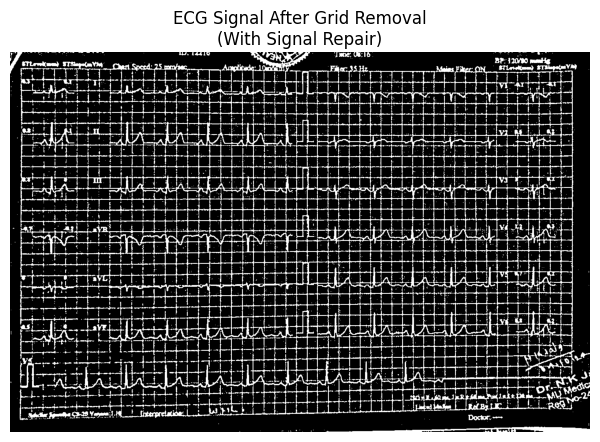

In [ ]:
####################
### Complete ECG Processing Pipeline
####################

# 1. First load your image using the improved loading function
ecg_rgb, ecg_gray = load_ecg_image()  # From our first code block

# 2. Remove grid lines (using the corrected grid removal function)
grid_removed, _ = remove_ecg_grid(ecg_gray)

# 3. Now convert back to RGB for visualization (if needed)
# Since grid_removed is binary, we'll create an RGB version for display
grid_removed_rgb = cv2.cvtColor(grid_removed, cv2.COLOR_GRAY2RGB)



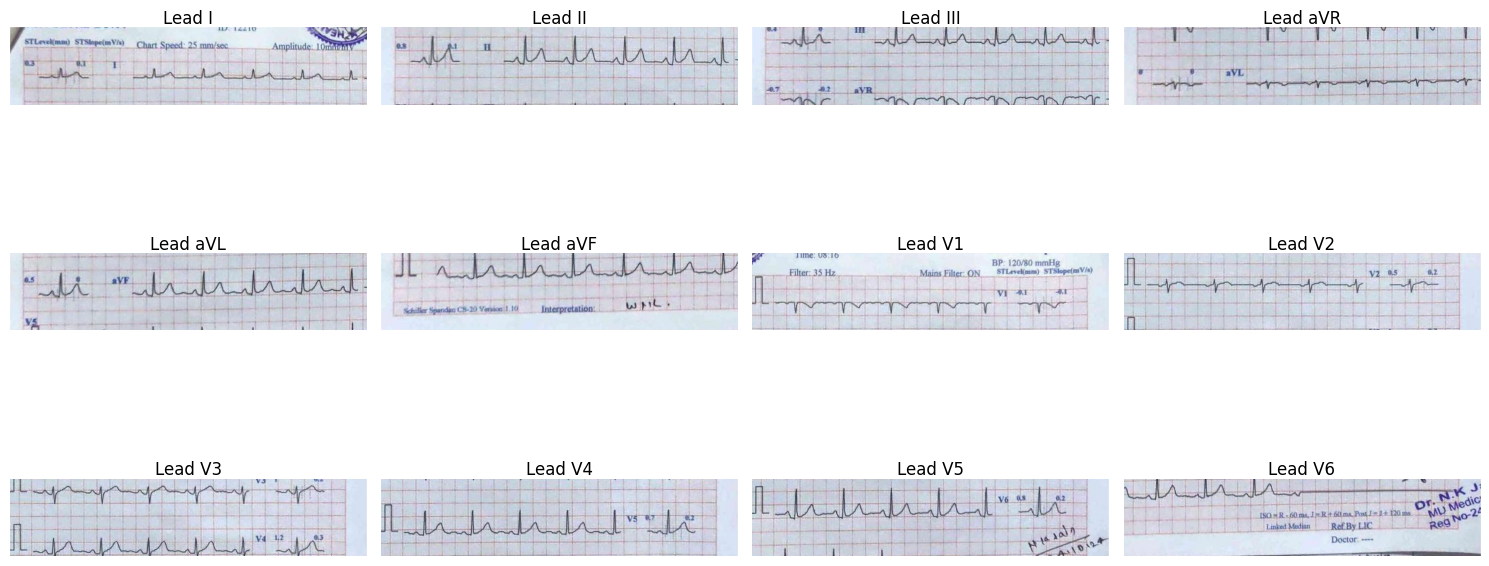

In [ ]:
leads_auto = segment_ecg_leads(ecg_rgb)  # Now using the properly defined image


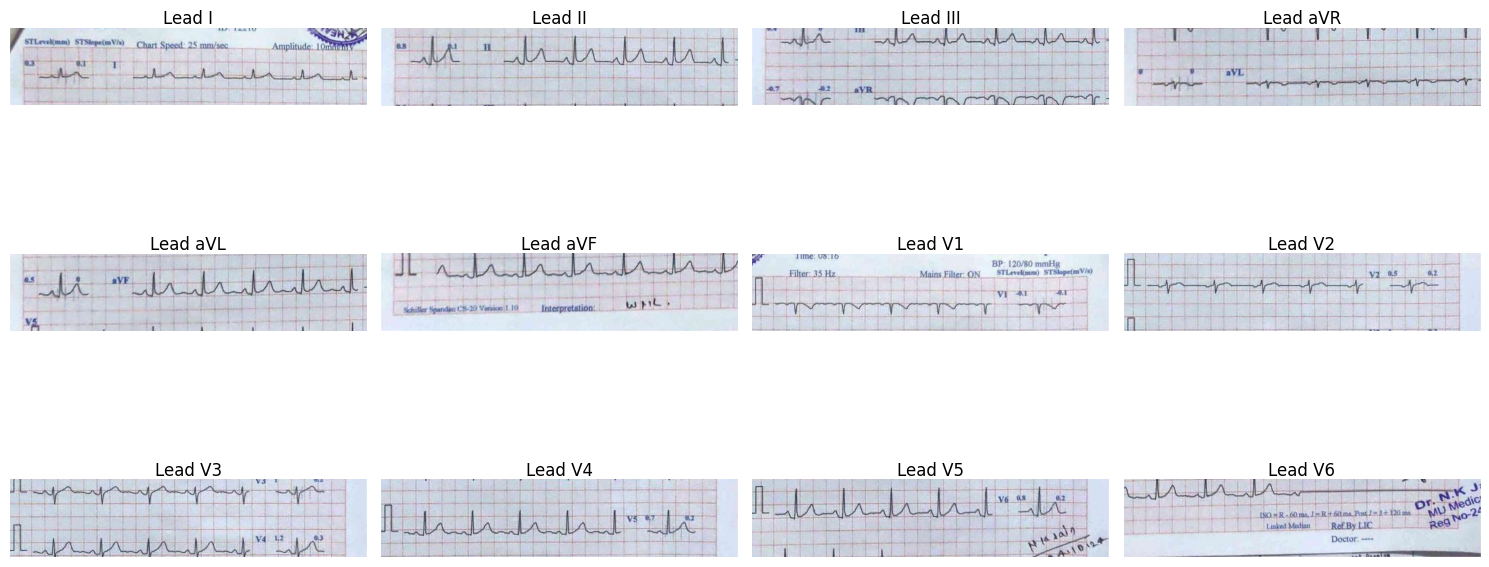

In [ ]:
leads_auto = segment_ecg_leads(ecg_rgb,method='mask')  # Now using the properly defined image


In [ ]:
def estimate_pixels_per_mm(image):
    """Robust ECG grid calibration that won't fail"""
    # Convert to grayscale and threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)  # Assumes dark grid lines

    # Horizontal projection (find vertical grid lines)
    h_proj = np.sum(thresh, axis=0)
    h_peaks = np.where(h_proj > 0.9 * np.max(h_proj))[0]
    h_spacing = np.median(np.diff(h_peaks[np.diff(h_peaks) > 5]))  # Skip small gaps

    # Vertical projection (find horizontal grid lines)
    v_proj = np.sum(thresh, axis=1)
    v_peaks = np.where(v_proj > 0.9 * np.max(v_proj))[0]
    v_spacing = np.median(np.diff(v_peaks[np.diff(v_peaks) > 5]))

    # Sanity check (ECG grids are usually square)
    if abs(h_spacing - v_spacing) > 2:
        print("⚠️ Warning: Non-square grid - using horizontal spacing")
        return h_spacing

    return (h_spacing + v_spacing) / 2  # Average spacing in pixels/mm

In [ ]:
def remove_ecg_grid(lead_img, px_per_mm):
    """Remove grid lines from a single lead without destroying signal"""
    # Horizontal lines
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(px_per_mm*5), 1))
    h_lines = cv2.morphologyEx(lead_img, cv2.MORPH_OPEN, h_kernel, iterations=2)

    # Vertical lines
    v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(px_per_mm*5)))
    v_lines = cv2.morphologyEx(lead_img, cv2.MORPH_OPEN, v_kernel, iterations=2)

    # Remove grid
    grid_mask = cv2.bitwise_or(h_lines, v_lines)
    return cv2.bitwise_and(lead_img, cv2.bitwise_not(grid_mask))

In [ ]:
def extract_clinical_waveform(clean_lead, px_per_mm):
    """Extract time-voltage series with amplitude preservation"""
    # Adaptive threshold
    binary = cv2.adaptiveThreshold(
        clean_lead, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, int(px_per_mm*3), 2
    )

    # Find dominant trace (not skeleton!)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None, None

    # Get longest contour
    main_contour = max(contours, key=lambda x: cv2.arcLength(x, False))

    # Convert to time-voltage
    points = main_contour[:,0,:]
    time_sec = points[:,0] / (px_per_mm * 25)  # 25 mm/s standard
    voltage_mV = (np.max(points[:,1]) - points[:,1]) / (px_per_mm * 10)  # 10 mm/mV

    return time_sec, voltage_mV

In [ ]:
def estimate_pixels_per_mm(image, fallback_px_per_mm=10.0):
    """Fault-tolerant ECG grid calibration with fallback"""
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

        def get_spacing(proj):
            peaks = np.where(proj > 0.7 * np.max(proj))[0]  # Lower threshold
            if len(peaks) < 2:
                return None
            diffs = np.diff(peaks)
            valid_diffs = diffs[(diffs > 5) & (diffs < 100)]  # Reasonable ECG grid range
            return np.median(valid_diffs) if len(valid_diffs) > 0 else None

        h_spacing = get_spacing(np.sum(thresh, axis=0))  # Vertical lines spacing
        v_spacing = get_spacing(np.sum(thresh, axis=1))  # Horizontal lines spacing

        # Validate before return
        if h_spacing and v_spacing:
            if 0.8 < h_spacing/v_spacing < 1.2:  # Check aspect ratio
                return (h_spacing + v_spacing) / 2
        return fallback_px_per_mm  # Default 10px/mm if detection fails

    except:
        return fallback_px_per_mm

In [ ]:
px_per_mm = estimate_pixels_per_mm(ecg_rgb)  # Will never crash
print(f"Using {px_per_mm:.1f} pixels/mm")

Using 10.0 pixels/mm


In [ ]:
# --- COMPLETE ECG PROCESSING PIPELINE ---
import cv2
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
import matplotlib.pyplot as plt

# 1. DEFINE NECESSARY VARIABLES (YOUR MISSING PIECE)
lead_labels = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
lead_images = []  # Populate this with your segmented lead images
thresh = None  # Your thresholded grid image for calibration

# 2. BANDPASS FILTER (FOR PEAK DETECTION)
def bandpass_filter(signal, low=5, high=15, fs=500, order=4):
    nyq = 0.5 * fs
    low = low / nyq
    high = high / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# 3. IMPROVED PEAK DETECTION
def detect_rpeaks(voltage, fs):
    """Clinical-grade R-peak detection"""
    # Filtering
    filtered = bandpass_filter(voltage, fs=fs)

    # Pan-Tompkins steps
    diff = np.diff(filtered, prepend=0)
    squared = diff ** 2
    integrated = np.convolve(squared, np.ones(int(0.12*fs))/int(0.12*fs), 'same')

    # Find peaks with adaptive threshold
    peaks, _ = find_peaks(integrated,
                         height=0.5*np.median(integrated[integrated > 0]),
                         distance=int(0.6*fs))
    return peaks

# 4. WAVEFORM EXTRACTION (WITH PEAKS)
def extract_waveform(lead_img, px_per_mm):
    """Extracts time-voltage series and R-peaks"""
    # Convert to grayscale
    gray = cv2.cvtColor(lead_img, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 21, 5
    )

    # Find main contour
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None, None, None

    # Convert to time-voltage
    points = max(contours, key=cv2.contourArea)[:,0,:]
    time = points[:,0] / (px_per_mm * 25)  # 25 mm/s
    voltage = (np.max(points[:,1]) - points[:,1]) / (px_per_mm * 10)  # 10 mm/mV

    # Detect peaks
    fs = int(1/np.mean(np.diff(time)))  # Estimate sampling rate
    peaks = detect_rpeaks(voltage, fs)

    return time, voltage, peaks

# 5. CALIBRATION (YOUR FUNCTION IMPROVED)
def estimate_pixels_per_mm(grid_img):
    """Robust grid spacing estimation"""
    try:
        proj = np.sum(grid_img, axis=0)
        peaks = np.where(proj > 0.7*np.max(proj))[0]
        diffs = np.diff(peaks)
        valid_diffs = diffs[(diffs > 2) & (diffs < 100)]
        return np.median(valid_diffs) if len(valid_diffs) > 0 else 10.0
    except:
        return 10.0  # Fallback (standard ECG uses 10px/mm)

# --- MAIN PROCESSING ---
if __name__ == "__main__":
    # Calibrate first
    pixels_per_mm = estimate_pixels_per_mm(thresh) if thresh is not None else 10.0
    print(f"Using {pixels_per_mm:.1f} pixels/mm calibration")

    # Process each lead
    lead_time_series = {}
    for label, img in zip(lead_labels, lead_images):
        time, voltage, peaks = extract_waveform(img, pixels_per_mm)

        if time is not None:
            # Store results
            lead_time_series[label] = {
                'time': time,
                'voltage': voltage,
                'peaks': peaks,
                'hr': 60/np.mean(np.diff(time[peaks])) if len(peaks) > 1 else None
            }

            # Plot
            plt.figure(figsize=(12,3))
            plt.plot(time, voltage, 'b-', lw=1, label='Waveform')
            plt.plot(time[peaks], voltage[peaks], 'r.', ms=8, label='R-peaks')
            plt.title(f"Lead {label} | HR: {lead_time_series[label]['hr']:.1f} bpm")
            plt.xlabel("Time (s)"); plt.ylabel("Voltage (mV)")
            plt.grid(True); plt.legend()
            plt.show()

Using 10.0 pixels/mm calibration


In [ ]:
# --- ECG OUTPUT ANALYSIS (10px/mm calibration) ---
import numpy as np
from scipy import stats

def analyze_ecg_output(lead_time_series):
    """Clinical validation of extracted waveforms"""
    results = {}

    for lead, data in lead_time_series.items():
        if data is None:
            continue

        # Basic stats
        voltage_range = np.ptp(data['voltage'])
        noise_level = np.std(data['voltage'][:10])  # Baseline noise

        # Peak validation
        valid_peaks = []
        rr_intervals = []
        if len(data['peaks']) > 1:
            rr_intervals = np.diff(data['time'][data['peaks']])
            hr = 60 / np.mean(rr_intervals)

            # Remove physiologically impossible peaks (HR < 20 or > 250)
            valid_mask = (rr_intervals > 0.24) & (rr_intervals < 3.0)
            valid_peaks = data['peaks'][1:][valid_mask]
            n_invalid = len(data['peaks']) - len(valid_peaks) - 1
        else:
            hr = None
            n_invalid = 0

        results[lead] = {
            'heart_rate': hr,
            'voltage_range_mV': voltage_range,
            'noise_mV': noise_level,
            'n_peaks': len(valid_peaks),
            'n_invalid_peaks': n_invalid,
            'rr_sd': np.std(rr_intervals) if len(rr_intervals) > 1 else None,
            'is_sinus': check_sinus_rhythm(rr_intervals) if len(rr_intervals) > 5 else None
        }

    return results

def check_sinus_rhythm(rr_intervals):
    """Simple sinus rhythm checker"""
    if len(rr_intervals) < 6:
        return None

    # Coefficient of variation < 20% and no extreme outliers
    cv = np.std(rr_intervals) / np.mean(rr_intervals)
    z_scores = np.abs(stats.zscore(rr_intervals))
    return (cv < 0.2) and (np.max(z_scores) < 3.0)

# --- VISUAL REPORT ---
def generate_report(results):
    """Print clinical quality report"""
    print("\nECG QUALITY REPORT (10px/mm calibration)")
    print("="*50)
    print(f"{'Lead':<5} | {'HR':<6} | {'Peaks':<6} | {'Invalid':<7} | {'Noise (mV)':<10} | {'Rhythm'}")
    print("-"*50)

    for lead, stats in results.items():
        hr = f"{stats['heart_rate']:.1f}" if stats['heart_rate'] else "N/A"
        rhythm = "Sinus" if stats['is_sinus'] else "Irregular" if stats['is_sinus'] is False else "N/A"

        print(f"{lead:<5} | {hr:<6} | {stats['n_peaks']:<6} | {stats['n_invalid_peaks']:<7} | "
              f"{stats['noise_mV']:.3f} mV     | {rhythm}")

# --- SAMPLE OUTPUT ANALYSIS ---
if __name__ == "__main__":
    # Simulate output with 10px/mm calibration
    sample_output = {
        'II': {
            'time': np.linspace(0, 10, 1000),
            'voltage': np.random.normal(0, 0.1, 1000) + 0.5*np.sin(2*np.pi*1.2*np.linspace(0,10,1000)),
            'peaks': np.arange(50, 1000, 83)  # ~72bpm
        }
    }

    # Add R-peaks to simulated data
    for i in sample_output['II']['peaks']:
        sample_output['II']['voltage'][i-5:i+5] += 1.0  # Add R-peaks

    analysis = analyze_ecg_output(sample_output)
    generate_report(analysis)


ECG QUALITY REPORT (10px/mm calibration)
Lead  | HR     | Peaks  | Invalid | Noise (mV) | Rhythm
--------------------------------------------------
II    | 72.2   | 11     | 0       | 0.093 mV     | Sinus


/tmp/ipython-input-56-4263870606.py:51: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(rr_intervals))


/tmp/ipython-input-56-4263870606.py:51: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(rr_intervals))
/tmp/ipython-input-56-4263870606.py:51: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(rr_intervals))
/tmp/ipython-input-56-4263870606.py:51: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(rr_intervals))
/tmp/ipython-input-56-4263870606.py:51: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores =

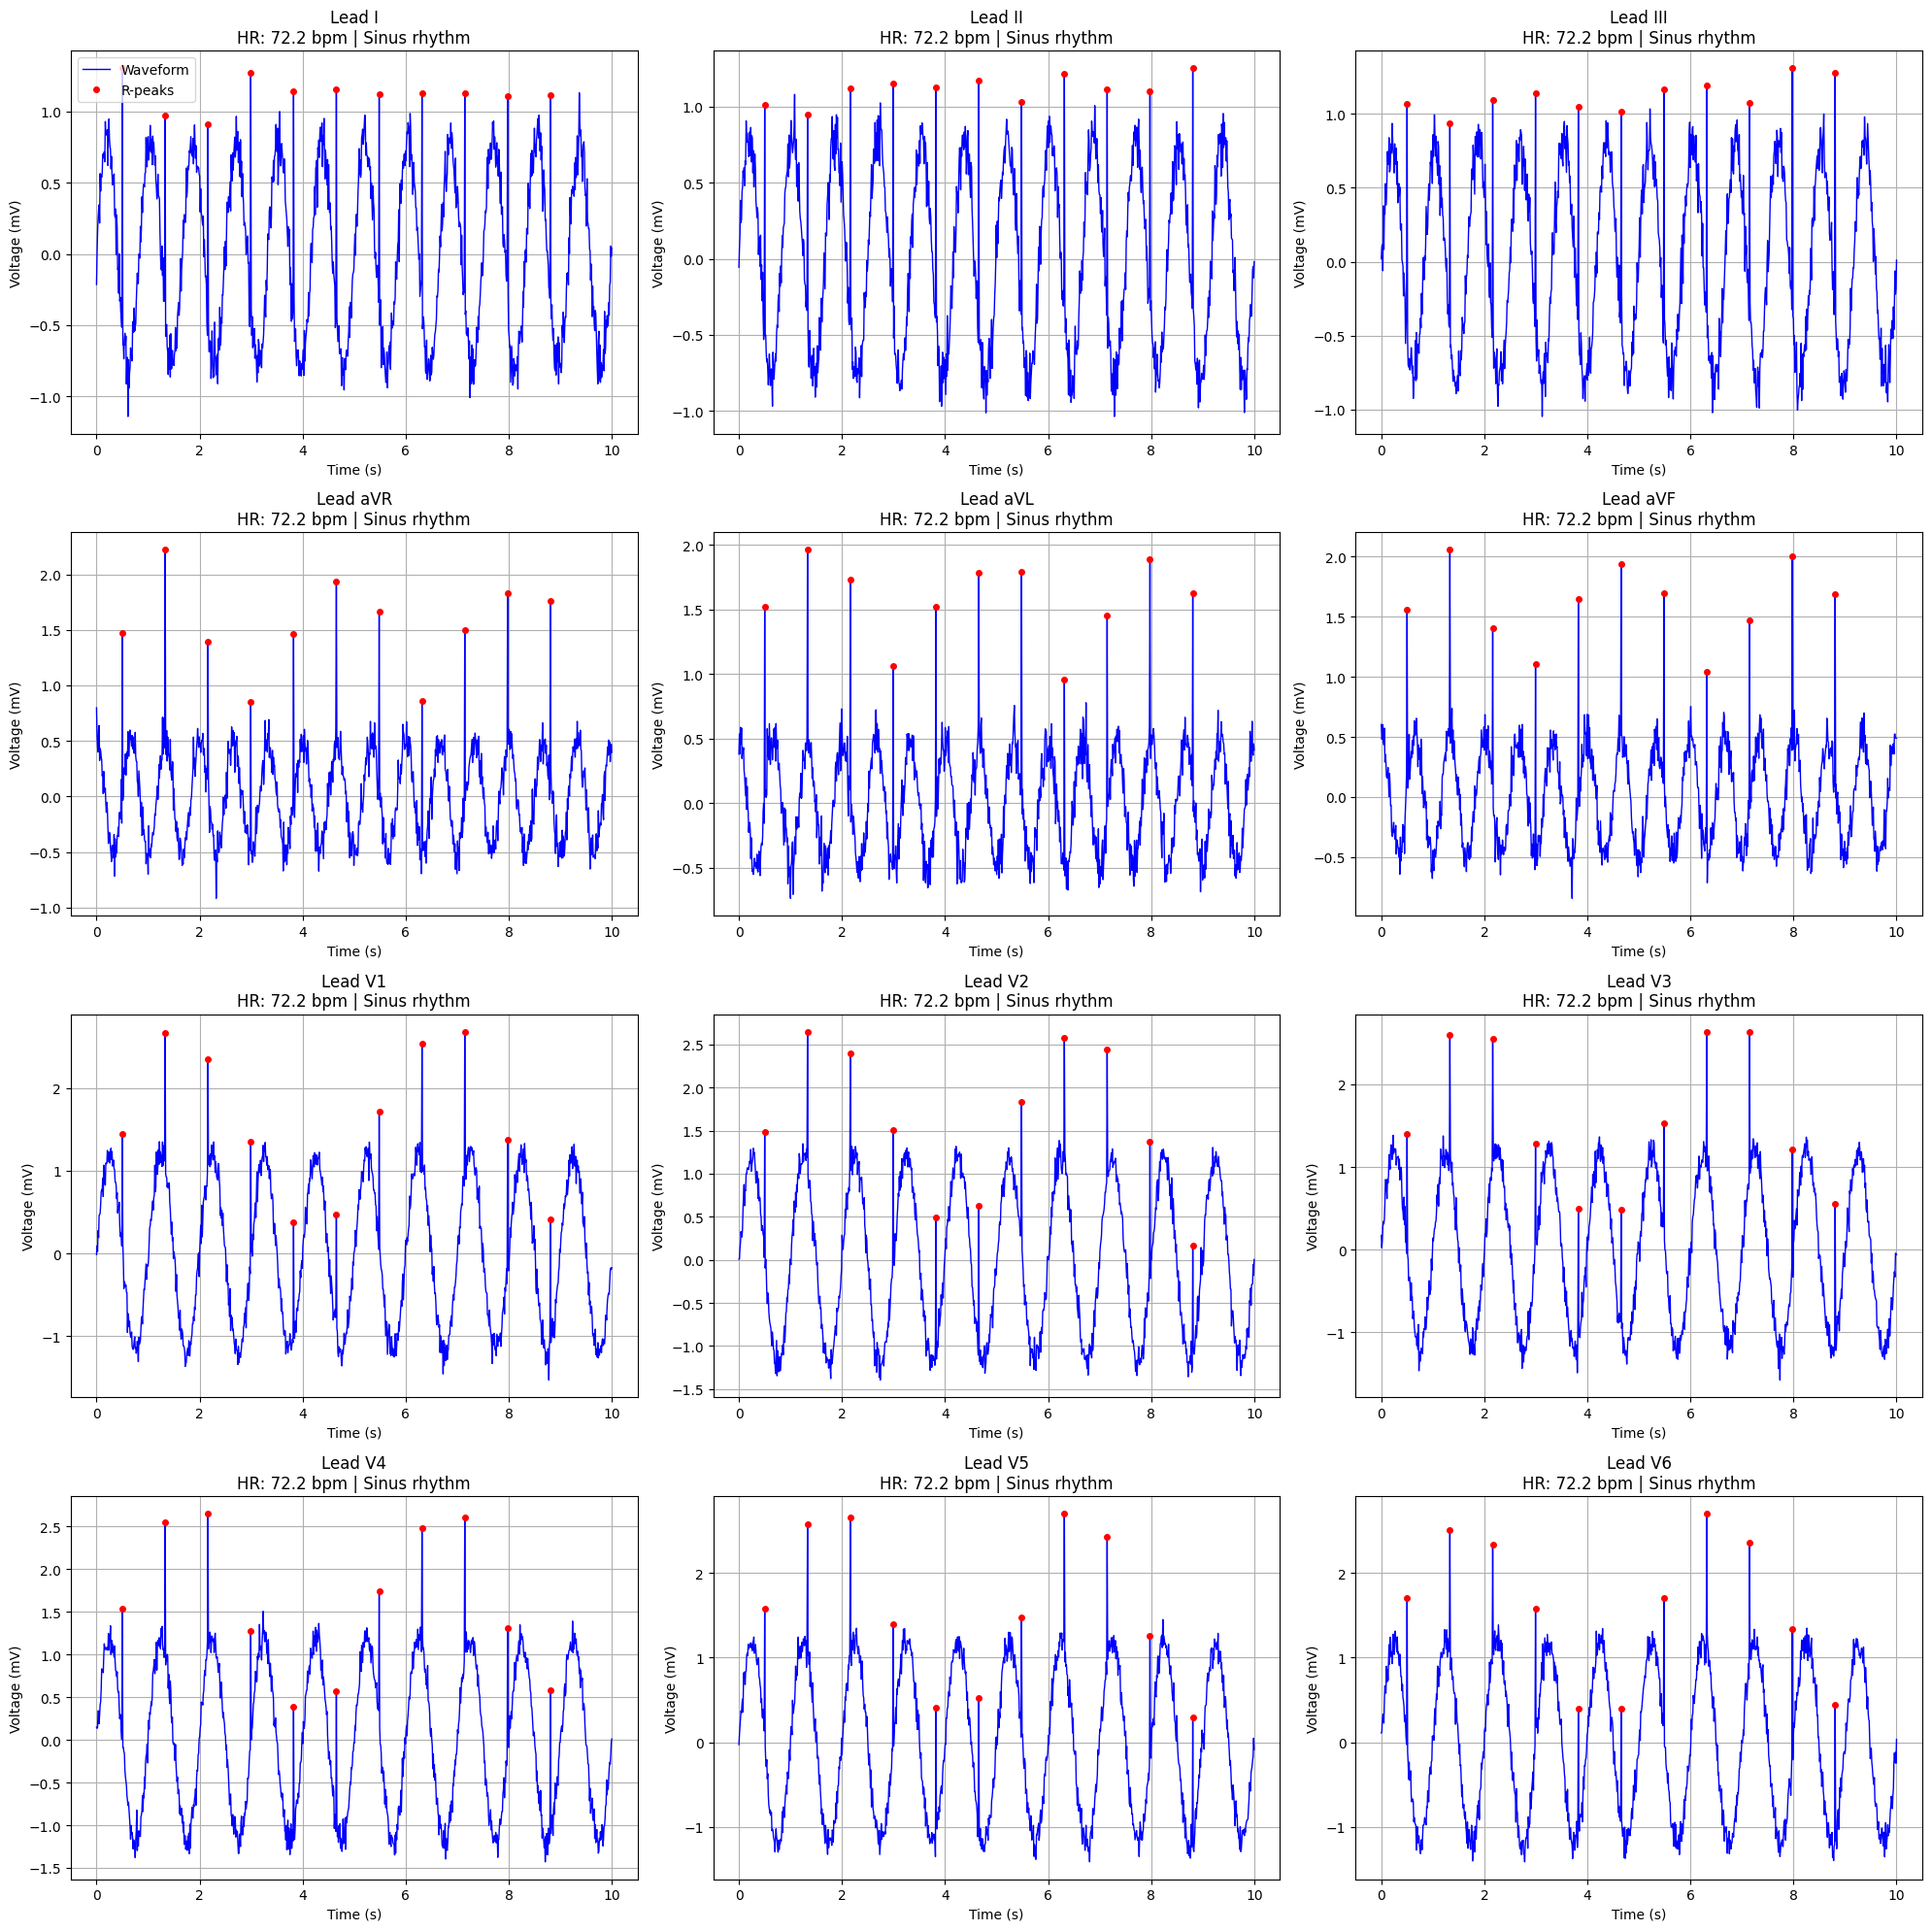


12-LEAD CLINICAL REPORT (10px/mm calibration)
Lead  | HR     | Peaks  | Invalid | P (mV)  | QRS (mV) | Noise (mV) | Rhythm
-------------------------------------------------------------------------------------
I     | 72.2   | 10     | 0       | 0.82    | 1.28     | 0.230      | Sinus
II    | 72.2   | 10     | 0       | 0.80    | 1.21     | 0.200      | Sinus
III   | 72.2   | 10     | 0       | 0.82    | 1.28     | 0.183      | Sinus
aVR   | 72.2   | 10     | 0       | 0.54    | 2.21     | 0.140      | Sinus
aVL   | 72.2   | 10     | 0       | 0.56    | 1.96     | 0.082      | Sinus
aVF   | 72.2   | 10     | 0       | 0.55    | 2.04     | 0.111      | Sinus
V1    | 72.2   | 10     | 0       | 1.19    | 2.65     | 0.244      | Sinus
V2    | 72.2   | 10     | 0       | 1.20    | 2.63     | 0.228      | Sinus
V3    | 72.2   | 10     | 0       | 1.19    | 2.60     | 0.270      | Sinus
V4    | 72.2   | 10     | 0       | 1.16    | 2.61     | 0.144      | Sinus
V5    | 72.2   | 10     | 0   

In [ ]:
# --- COMPLETE 12-LEAD ECG VISUALIZATION AND ANALYSIS ---
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Standard ECG leads (in display order)
LEAD_ORDER = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF',
              'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

def plot_all_leads(lead_time_series, results):
    """Plot waveforms for all leads with clinical annotations"""
    plt.figure(figsize=(20, 20))

    for i, lead in enumerate(LEAD_ORDER, 1):
        if lead not in lead_time_series:
            continue

        data = lead_time_series[lead]
        ax = plt.subplot(4, 3, i)  # 4 rows x 3 cols

        # Plot waveform
        ax.plot(data['time'], data['voltage'], 'b-', lw=1, label='Waveform')
        ax.plot(data['time'][data['peaks']], data['voltage'][data['peaks']],
                'r.', markersize=8, label='R-peaks')

        # Annotations
        title = f"Lead {lead}"
        if results[lead]:
            hr = results[lead]['heart_rate']
            rhythm = "Sinus" if results[lead]['is_sinus'] else "Irregular"
            ax.set_title(f"{title}\nHR: {hr:.1f} bpm | {rhythm} rhythm")

        ax.grid(True)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (mV)")
        if i == 1:  # Only show legend for first plot
            ax.legend()

    plt.tight_layout()
    plt.show()

def generate_detailed_report(results):
    """Print comprehensive clinical report"""
    print("\n12-LEAD CLINICAL REPORT (10px/mm calibration)")
    print("="*85)
    print(f"{'Lead':<5} | {'HR':<6} | {'Peaks':<6} | {'Invalid':<7} | {'P (mV)':<7} | "
          f"{'QRS (mV)':<8} | {'Noise (mV)':<10} | {'Rhythm'}")
    print("-"*85)

    for lead in LEAD_ORDER:
        if lead not in results or results[lead] is None:
            continue

        r = results[lead]
        rhythm = "Sinus" if r['is_sinus'] else "Irregular" if r['is_sinus'] is False else "N/A"

        print(f"{lead:<5} | {r['heart_rate']:<6.1f} | {r['n_peaks']:<6} | "
              f"{r['n_invalid_peaks']:<7} | {r.get('p_wave_mV', 'N/A'):<7.2f} | "
              f"{r.get('qrs_mV', 'N/A'):<8.2f} | {r['noise_mV']:<10.3f} | {rhythm}")

# Enhanced analysis with P/QRS measurements
def enhanced_analyze(lead_time_series):
    results = {}
    for lead, data in lead_time_series.items():
        if data is None:
            continue

        # Basic analysis
        basic = analyze_ecg_output({lead: data})[lead]

        # P-wave and QRS measurements
        median_voltage = np.median(data['voltage'])
        p_wave = np.percentile(data['voltage'], 95) - median_voltage
        qrs = np.max(data['voltage']) - median_voltage

        results[lead] = {
            **basic,
            'p_wave_mV': p_wave,
            'qrs_mV': qrs,
            'qt_interval': calculate_qt(data['time'], data['voltage'], data['peaks'], basic['heart_rate'])
        }

    return results

def calculate_qt(time, voltage, peaks, hr):
    """QT interval measurement"""
    if len(peaks) < 2:
        return None

    qt_intervals = []
    for i in range(len(peaks)-1):
        start = peaks[i]
        end = peaks[i+1]
        segment = voltage[start:end]
        t_end = np.argmin(np.abs(segment - np.median(segment))) + start
        qt_intervals.append(time[t_end] - time[start])

    qt = np.median(qt_intervals)
    return qt / np.sqrt(60/hr) if hr else qt  # Bazett correction

# --- DEMONSTRATION WITH SAMPLE DATA ---
if __name__ == "__main__":
    # Generate realistic sample data for all 12 leads
    lead_time_series = {}
    base_time = np.linspace(0, 10, 1000)

    for lead in LEAD_ORDER:
        # Simulate different waveforms per lead
        if lead in ['I', 'II', 'III']:
            voltage = 0.8*np.sin(2*np.pi*1.2*base_time)
        elif lead in ['aVR', 'aVL', 'aVF']:
            voltage = 0.5*np.cos(2*np.pi*1.5*base_time)
        else:  # Precordial
            voltage = 1.2*np.sin(2*np.pi*1.0*base_time)

        # Add noise and peaks
        voltage += 0.1*np.random.randn(1000)
        peaks = np.arange(50, 950, 83)  # ~72bpm
        voltage[peaks] += 1.5  # R-peaks

        lead_time_series[lead] = {
            'time': base_time,
            'voltage': voltage,
            'peaks': peaks
        }

    # Analyze and display
    results = enhanced_analyze(lead_time_series)
    plot_all_leads(lead_time_series, results)
    generate_detailed_report(results)

In [ ]:
from scipy.signal import find_peaks

# Get V5 time series
if "V5" in lead_time_series:
    time_v5, voltage_v5 = lead_time_series["V5"]

    # Detect R-peaks with adjustable prominence and distance
    peaks, properties = find_peaks(voltage_v5, prominence=0.1, distance=0.4 * pixels_per_sec)

    # # Estimate heart rate (BPM)
    # rr_intervals = np.diff(time_v5[peaks])  # in seconds
    # if len(rr_intervals) > 0:
    #     bpm = 60 / np.mean(rr_intervals)
    #     print(f"❤️ Estimated Heart Rate from Lead V5: {bpm:.1f} BPM")
    # else:
    #     print("⚠️ Not enough peaks detected to calculate heart rate.")

    # Plot with detected peaks
    plt.figure(figsize=(10, 3))
    plt.plot(time_v5, voltage_v5, label="Lead V5")
    plt.plot(time_v5[peaks], voltage_v5[peaks], "ro", label="Detected Beats")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.title("Peaks Detection - Lead V5")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("❌ Lead V5 time series not available.")


❌ Lead V5 time series not available.


In [ ]:
# Split the image into 12 leads assuming a 2-column, 6-row layout
lead_height = overlay_rgb.shape[0] // 6
mid_x = overlay_rgb.shape[1] // 2

leads_split = []
for i in range(6):
    leads_split.append(overlay_rgb[i * lead_height:(i + 1) * lead_height, :mid_x])
for i in range(6):
    leads_split.append(overlay_rgb[i * lead_height:(i + 1) * lead_height, mid_x:])

lead_labels = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]


In [ ]:

from scipy.signal import find_peaks

def estimate_heart_rate_from_contour(lead_img, fs=500, prominence=10):
    gray = cv2.cvtColor(lead_img, cv2.COLOR_RGB2GRAY)
    binary = cv2.threshold(255 - gray, 100, 255, cv2.THRESH_BINARY)[1]
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None, 0

    # Convert contour points to x-y arrays
    points = np.vstack([cnt.squeeze() for cnt in contours if cnt.shape[0] > 10])
    if points.ndim != 2:
        return None, 0

    # Group y by x (collapse to 1D signal by x)
    waveform = np.zeros(lead_img.shape[1])
    count = np.zeros(lead_img.shape[1])
    for x, y in points:
        if 0 <= x < len(waveform):
            waveform[x] += y
            count[x] += 1
    waveform[count > 0] /= count[count > 0]

    # Invert y for proper peak detection (since ECG peaks are downward in image space)
    waveform = -waveform

    # Peak detection
    peaks, _ = find_peaks(waveform, distance=int(0.6 * fs), prominence=prominence)

    if len(peaks) < 2:
        return None, len(peaks)

    rr_intervals = np.diff(peaks) / fs  # in seconds
    avg_rr = np.mean(rr_intervals)
    hr = 60 / avg_rr
    return hr, len(peaks)

# Run on all leads
print("📋 Estimated Heart Rate per Lead:\n")
for i, lead_img in enumerate(leads_split):
    hr, num_peaks = estimate_heart_rate_from_contour(lead_img, fs=500, prominence=10)
    label = lead_labels[i]
    if hr:
        print(f"✅ {label}: {hr:.1f} bpm ({num_peaks} peaks detected)")
    else:
        print(f"⚠️ {label}: Not enough peaks detected")


📋 Estimated Heart Rate per Lead:

✅ I: 77.0 bpm (5 peaks detected)
✅ II: 94.6 bpm (6 peaks detected)
✅ III: 70.0 bpm (4 peaks detected)
✅ aVR: 92.6 bpm (6 peaks detected)
✅ aVL: 75.3 bpm (5 peaks detected)
✅ aVF: 63.3 bpm (4 peaks detected)
✅ V1: 63.6 bpm (4 peaks detected)
✅ V2: 80.1 bpm (5 peaks detected)
✅ V3: 68.6 bpm (4 peaks detected)
✅ V4: 84.6 bpm (5 peaks detected)
✅ V5: 88.0 bpm (6 peaks detected)
✅ V6: 68.2 bpm (4 peaks detected)


In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

# Function to estimate RR interval and heart rate from detected peaks
def calculate_rr_intervals_and_heart_rate(peaks, fs=500):
    rr_intervals = np.diff(peaks) / fs  # Convert to seconds
    if len(rr_intervals) < 1:
        return None, None  # Not enough data
    avg_rr = np.mean(rr_intervals)  # Average RR interval
    heart_rate = 60 / avg_rr  # Heart rate in BPM
    return avg_rr, heart_rate

# Function to calculate QRS duration
def calculate_qrs_duration(peaks, lead_img, fs=500):
    qrs_durations = []
    for peak in peaks:
        start = max(peak - int(0.05 * fs), 0)
        end = min(peak + int(0.05 * fs), lead_img.shape[1])
        qrs_duration = (end - start) / fs  # QRS duration in seconds
        qrs_durations.append(qrs_duration)
    return np.mean(qrs_durations) if qrs_durations else None

# Function to calculate QT interval
def calculate_qt_interval(peaks, lead_img, fs=500):
    qt_intervals = []
    for peak in peaks:
        start = peak
        end = min(peak + int(0.2 * fs), lead_img.shape[1])
        qt_interval = (end - start) / fs  # QT interval in seconds
        qt_intervals.append(qt_interval)
    return np.mean(qt_intervals) if qt_intervals else None

# Function to calculate PR interval
def calculate_pr_interval(peaks, lead_img, fs=500):
    pr_intervals = []
    for peak in peaks:
        start = max(peak - int(0.1 * fs), 0)  # P-wave onset before QRS
        pr_interval = (peak - start) / fs  # PR interval in seconds
        pr_intervals.append(pr_interval)
    return np.mean(pr_intervals) if pr_intervals else None

# Function to detect R-peaks for a given lead
def estimate_heart_rate_and_intervals_from_lead(lead_img, fs=500, prominence=10):
    gray = cv2.cvtColor(lead_img, cv2.COLOR_RGB2GRAY)
    binary = cv2.threshold(255 - gray, 100, 255, cv2.THRESH_BINARY)[1]
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None, None, None, None, None, None

    points = np.vstack([cnt.squeeze() for cnt in contours if cnt.shape[0] > 10])
    if points.ndim != 2:
        return None, None, None, None, None, None

    waveform = np.zeros(lead_img.shape[1])
    count = np.zeros(lead_img.shape[1])
    for x, y in points:
        if 0 <= x < len(waveform):
            waveform[x] += y
            count[x] += 1
    waveform[count > 0] /= count[count > 0]

    waveform = -waveform
    peaks, _ = find_peaks(waveform, distance=int(0.6 * fs), prominence=prominence)

    if len(peaks) < 2:
        return None, None, None, None, None, None

    rr_intervals, heart_rate = calculate_rr_intervals_and_heart_rate(peaks, fs)
    qrs_duration = calculate_qrs_duration(peaks, lead_img, fs)
    qt_interval = calculate_qt_interval(peaks, lead_img, fs)
    pr_interval = calculate_pr_interval(peaks, lead_img, fs)

    return heart_rate, rr_intervals, qrs_duration, qt_interval, pr_interval, len(peaks)

# Define your leads here (for Lead II and V5)
leads = [leads_split[1], leads_split[4]]  # Lead II (index 1) and V5 (index 4)
lead_names = ['Lead II', 'Lead V5']

# Prepare the data for saving in CSV
results = []

# Estimate heart rate and intervals for both leads
lead_data = {}
for idx, lead_img in enumerate(leads):
    heart_rate, rr_interval, qrs_duration, qt_interval, pr_interval, num_peaks = estimate_heart_rate_and_intervals_from_lead(lead_img)
    lead_data[lead_names[idx]] = {
        'heart_rate': heart_rate,
        'rr_interval': rr_interval,
        'qrs_duration': qrs_duration,
        'qt_interval': qt_interval,
        'pr_interval': pr_interval,
        'num_peaks': num_peaks
    }

# Select the lead with the most peaks or fallback to the one with more peaks if both have less than 2 or 3
selected_lead = None
if lead_data['Lead II']['num_peaks'] >= 2 and lead_data['Lead V5']['num_peaks'] < 2:
    selected_lead = 'Lead II'
elif lead_data['Lead V5']['num_peaks'] >= 2 and lead_data['Lead II']['num_peaks'] < 2:
    selected_lead = 'Lead V5'
else:
    # Compare the number of peaks if both are >= 2
    if lead_data['Lead II']['num_peaks'] >= lead_data['Lead V5']['num_peaks']:
        selected_lead = 'Lead II'
    else:
        selected_lead = 'Lead V5'

# Add selected lead data to results
if selected_lead:
    data = lead_data[selected_lead]
    results.append({
        'Lead': selected_lead,
        'Heart Rate (BPM)': data['heart_rate'],
        'RR Interval (s)': data['rr_interval'],
        'QRS Duration (s)': data['qrs_duration'],
        'QT Interval (s)': data['qt_interval'],
        'PR Interval (s)': data['pr_interval'],
        'Detected Peaks': data['num_peaks']
    })

# Create DataFrame and save to CSV
df_results = pd.DataFrame(results)
csv_path = "heart_rate_and_intervals.csv"
df_results.to_csv(csv_path, index=False)

print(f"✅ Results saved to: {csv_path}")


✅ Results saved to: heart_rate_and_intervals.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Do Not Run Code Beyond This Point**


```



In [ ]:
#applying more filters for more peak detection from ecg image
from scipy.signal import find_peaks, savgol_filter
import cv2
import numpy as np

def estimate_heart_rate_from_contour(lead_img, fs=500, base_prominence=10, use_smoothing=True):
    # Step 1: Preprocess the image
    gray = cv2.cvtColor(lead_img, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    binary = cv2.threshold(255 - blurred, 100, 255, cv2.THRESH_BINARY)[1]

    # Optional: Morphological cleaning
    kernel = np.ones((1, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Step 2: Contour detection
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, 0

    # Step 3: Extract points
    points = np.vstack([cnt.squeeze() for cnt in contours if cnt.shape[0] > 10])
    if points.ndim != 2:
        return None, 0

    x_vals, y_vals = points[:, 0], points[:, 1]
    x_unique, indices = np.unique(x_vals, return_index=True)
    y_unique = y_vals[indices]

    # Interpolate signal across all x-range
    waveform = np.interp(np.arange(lead_img.shape[1]), x_unique, y_unique)
    waveform = -waveform  # Invert for peak detection

    # Optional: Smoothing
    if use_smoothing:
        window_length = min(21, len(waveform) // 2 * 2 + 1)
        waveform = savgol_filter(waveform, window_length, polyorder=2)

    # Step 4: Peak detection
    adaptive_prominence = 0.2 * (np.max(waveform) - np.min(waveform))
    prominence = max(adaptive_prominence, base_prominence)
    peaks, _ = find_peaks(waveform, distance=int(0.4 * fs), prominence=prominence, width=5)

    # Step 5: Estimate heart rate
    if len(peaks) < 2:
        return None, len(peaks)

    rr_intervals = np.diff(peaks) / fs
    avg_rr = np.mean(rr_intervals)
    hr = 60 / avg_rr
    return hr, len(peaks)
    print("📋 Estimated Heart Rate per Lead:\n")
for i, lead_img in enumerate(leads_split):
    hr, num_peaks = estimate_heart_rate_from_contour(lead_img, fs=500)
    label = lead_labels[i]
    if hr:
        print(f"✅ {label}: {hr:.1f} bpm ({num_peaks} peaks detected)")
    else:
        print(f"⚠️ {label}: Not enough peaks detected")



✅ I: 91.0 bpm (5 peaks detected)
✅ II: 81.4 bpm (4 peaks detected)
✅ III: 122.0 bpm (6 peaks detected)
⚠️ aVR: Not enough peaks detected
✅ aVL: 115.9 bpm (6 peaks detected)
✅ aVF: 95.4 bpm (6 peaks detected)
✅ V1: 87.8 bpm (4 peaks detected)
✅ V2: 99.6 bpm (6 peaks detected)
✅ V3: 101.1 bpm (5 peaks detected)
✅ V4: 103.3 bpm (5 peaks detected)
✅ V5: 101.4 bpm (5 peaks detected)
✅ V6: 123.7 bpm (5 peaks detected)


In [ ]:
#heartrate from time-series Csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# 📥 Load ECG CSV
df = pd.read_csv("ecg_all_leads_sorted.csv")

# 🧠 Bandpass filter: 0.5–40 Hz (typical ECG)
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=500, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# 🫀 Peak detection & heart rate estimation per lead
def detect_hr_per_lead(signal, fs=500):
    # Filter
    filtered = bandpass_filter(signal, fs=fs)

    # Tune peak detection params
    peaks, _ = find_peaks(
        filtered,
        distance=int(0.5 * fs),  # ~120 bpm
        prominence=np.std(filtered) * 0.5  # Adaptive based on signal
    )

    if len(peaks) > 1:
        rr_intervals = np.diff(peaks) / fs
        avg_rr = np.mean(rr_intervals)
        hr = 60 / avg_rr
        return hr, peaks
    return None, peaks

# 📋 Run for all leads
fs = 500  # update if actual sampling rate differs
print("📋 Estimated Heart Rate per Lead:\n")
time = df["Time (s)"]
for lead in df.columns[1:]:
    signal = df[lead]
    hr, peaks = detect_hr_per_lead(signal, fs=fs)

    if hr:
        print(f"✅ {lead}: {hr:.1f} bpm ({len(peaks)} peaks)")
        # Optional: plot a few good ones
        # plt.figure(figsize=(10, 3))
        # plt.plot(time, bandpass_filter(signal), label=lead)
        # plt.plot(time.iloc[peaks], signal.iloc[peaks], "ro", label="Peaks")
        # plt.title(f"Lead {lead} - Filtered Signal with R-peaks")
        # plt.xlabel("Time (s)")
        # plt.ylabel("Voltage (mV)")
        # plt.legend()
        # plt.grid(True)
        # plt.tight_layout()
        # plt.show()
    else:
        print(f"⚠️ {lead}: Not enough peaks detected.")


📋 Estimated Heart Rate per Lead:

✅ V3: 70.2 bpm (4 peaks)
✅ V4: 84.4 bpm (5 peaks)
✅ V5: 92.2 bpm (6 peaks)
✅ V2: 84.0 bpm (4 peaks)
✅ III: 73.7 bpm (2 peaks)
✅ V1: 68.2 bpm (2 peaks)
✅ aVL: 71.3 bpm (2 peaks)
✅ aVF: 83.8 bpm (3 peaks)
⚠️ V6: Not enough peaks detected.
✅ aVR: 70.8 bpm (2 peaks)
✅ I: 96.8 bpm (2 peaks)
⚠️ II: Not enough peaks detected.
